In [286]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

In [287]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import os
import json
import zipfile
import networkx as nx
import statsmodels.api as sm

from tqdm import tqdm
from matplotlib import rc
from matplotlib import colormaps
from collections import defaultdict

In [288]:
df = pd.read_csv("../data/cl_papers.csv", sep=",", index_col=0)
df.head()

,id,title,area,source,year,doi,abstract,semantic_scholar_id
0,main.1004,AnswerFact: Fact Checking in Product Question ...,Question Answering,EMNLP,2020,10.18653/v1/2020.emnlp-main.188,Product-related question answering platforms n...,4c61df1b4b9a164fec1a34587b4fffae029cd18c
1,main.1006,Knowledge-Grounded Dialogue Generation with Pr...,Dialog and Interactive Systems,EMNLP,2020,10.18653/v1/2020.emnlp-main.272,We study knowledge-grounded dialogue generatio...,3447a432f724aa36595643446acda5b78943db19
2,main.1009,BiST: Bi-directional Spatio-Temporal Reasoning...,Dialog and Interactive Systems,EMNLP,2020,10.18653/v1/2020.emnlp-main.145,Video-grounded dialogues are very challenging ...,f4a2acfeb1705df3f430cc53ace26e1dbbbcbd16
3,main.1010,A Knowledge-Aware Sequence-to-Tree Network for...,NLP Applications,EMNLP,2020,10.18653/v1/2020.emnlp-main.579,With the advancements in natural language proc...,24ed85ad966823868c1694a19385d01c6ad71008
4,main.1011,Knowledge Association with Hyperbolic Knowledg...,Information Extraction,EMNLP,2020,10.18653/v1/2020.emnlp-main.460,Capturing associations for knowledge graphs (K...,3d61a28b9429fc8f7047fc379a0134a3765edbcb


In [289]:
raw_tracks = set(df['area'])

raw_tracks

{'Applications',
 'Area A (Information Extraction and Question Answering) [LONG]',
 'Area A from Area F (Discourse, Dialog, Summarization, Generation, Multimodal NLP) [LONG]',
 'Area B (Text Mining and Information Retrieval) [LONG]',
 'Area C (Social Media, Computational Social Science, Sentiment,  Opinion) [LONG]',
 'Area D (Morphology, Syntax, Chunking, Psycholinguistics) [LONG]',
 'Area E (Semantics) [LONG]',
 'Area F (Discourse, Dialog, Summarization, Generation, Multimodal NLP) [LONG]',
 'Area G (Machine Translation and Multilinguality) [LONG]',
 'Area H (Machine Learning) [LONG]',
 'Area H or D',
 'Argument Mining',
 'Best Paper Session',
 'Bias in Language Processing',
 'Cognitive Modeling and Psycholinguistics',
 'Commonsense Reasoning',
 'Computational Social Science and Cultural Analytics',
 'Computational Social Science and Social Media',
 'Dialog System',
 'Dialog System, Discourse',
 'Dialog and Interactive Systems',
 'Dialog and Interactive Systems, Machine Translation an

In [290]:
analysis_or_interpretability_tracks = list(filter(lambda x: 'interpretability' in x.lower() or 'analysis of language models' in x.lower(), raw_tracks))
print('interp & analysis tracks')
print(analysis_or_interpretability_tracks)
print()

syntax_tracks = list(filter(lambda x: 'syntax' in x.lower(), raw_tracks))
print('syntax tracks')
print(syntax_tracks)
print()

mt_tracks = list(filter(lambda x: 'translation' in x.lower(), raw_tracks))
print('MT tracks')
print(mt_tracks)
print()

grounding_tracks = list(filter(lambda x: 'grounding' in x.lower(), raw_tracks))
print('grounding tracks')
print(grounding_tracks)
print()

semantics_tracks = list(filter(lambda x: 'semantics' in x.lower(), raw_tracks))
print('semantics tracks')
print(semantics_tracks)
print()

evaluation_tracks = list(filter(lambda x: 'evaluation' in x.lower(), raw_tracks))
print('evaluation tracks')
print(evaluation_tracks)
print()

info_extraction_tracks = list(filter(lambda x: 'extraction' in x.lower(), raw_tracks))
print('info_extraction tracks')
print(info_extraction_tracks)
print()

qa_tracks = list(filter(lambda x: 'answering' in x.lower(), raw_tracks))
print('qa_tracks')
print(qa_tracks)
print()

dialogue_tracks = list(filter(lambda x: 'dialog' in x.lower(), raw_tracks))
print('dialogue_tracks')
print(dialogue_tracks)
print()

sentiment_analysis_tracks = list(filter(lambda x: 'sentiment analysis' in x.lower(), raw_tracks))
print('sentiment_analysis_tracks')
print(sentiment_analysis_tracks)
print()

interp & analysis tracks
['Interpretability and Analysis of Models for NLP', 'Language Modeling and Analysis of Language Models', 'Interpretability, Interactivity and Analysis of Models for NLP', 'Interpretability, Interactivity, and Analysis of Models for NLP']

syntax tracks
['Syntax: Tagging, Chunking and Parsing', 'Tagging, Chunking, Syntax and Parsing', 'Syntax, Parsing and their Applications', 'Area D (Morphology, Syntax, Chunking, Psycholinguistics) [LONG]', 'Dialog and Interactive Systems, Machine Translation and Multilinuality, Phonology, Morphology, and Word Segmentation, Speech, Vision, Robotics, Multimodal and Grounding, Tagging, Chunking, Syntax and Parsing', 'Syntax, Parsing, and Linguistic Theories', 'Machine Translation and Mulitilinguality, Phonology, Morphology and Word Segmentation, Tagging, Chunking, Syntax and Parsing', 'Syntax: Tagging, Chunking, and Parsing']

MT tracks
['Area G (Machine Translation and Multilinguality) [LONG]', 'Machine Translation and Multiling

In [291]:
def raw_track_to_track(raw_track):
    if raw_track in analysis_or_interpretability_tracks:
        return 'Interpretability and Analysis'
    if raw_track in syntax_tracks:
        return 'Syntax'
    if raw_track in mt_tracks:
        return 'Machine Translation'
    if raw_track in grounding_tracks:
        return 'Grounding'
    if raw_track in semantics_tracks:
        return 'Semantics'
    if raw_track in evaluation_tracks:
        return 'Evaluation'
    if raw_track in info_extraction_tracks:
        return 'Information Extraction'
    if raw_track in qa_tracks:
        return 'Question Answering'
    if raw_track in dialogue_tracks:
        return 'Dialogue'
    if raw_track in sentiment_analysis_tracks:
        return 'Dialogue'
    return None


df['track'] = df['area'].apply(raw_track_to_track)
df

,id,title,area,source,year,doi,abstract,semantic_scholar_id,track
0,main.1004,AnswerFact: Fact Checking in Product Question ...,Question Answering,EMNLP,2020,10.18653/v1/2020.emnlp-main.188,Product-related question answering platforms n...,4c61df1b4b9a164fec1a34587b4fffae029cd18c,Question Answering
1,main.1006,Knowledge-Grounded Dialogue Generation with Pr...,Dialog and Interactive Systems,EMNLP,2020,10.18653/v1/2020.emnlp-main.272,We study knowledge-grounded dialogue generatio...,3447a432f724aa36595643446acda5b78943db19,Dialogue
2,main.1009,BiST: Bi-directional Spatio-Temporal Reasoning...,Dialog and Interactive Systems,EMNLP,2020,10.18653/v1/2020.emnlp-main.145,Video-grounded dialogues are very challenging ...,f4a2acfeb1705df3f430cc53ace26e1dbbbcbd16,Dialogue
3,main.1010,A Knowledge-Aware Sequence-to-Tree Network for...,NLP Applications,EMNLP,2020,10.18653/v1/2020.emnlp-main.579,With the advancements in natural language proc...,24ed85ad966823868c1694a19385d01c6ad71008,None
4,main.1011,Knowledge Association with Hyperbolic Knowledg...,Information Extraction,EMNLP,2020,10.18653/v1/2020.emnlp-main.460,Capturing associations for knowledge graphs (K...,3d61a28b9429fc8f7047fc379a0134a3765edbcb,Information Extraction
...,...,...,...,...,...,...,...,...,...
9250,T4773,Rank-Aware Negative Training for Semi-Supervis...,Machine Learning for NLP,ACL,2023,10.1162/tacl_a_00574,Abstract Semi-supervised text classification-b...,79a502caa0b12573f56a7e8948459722aa891479,None
9251,T4777,Transparency Helps Reveal When Language Models...,"Linguistic Theories, Cognitive Modeling, and P...",ACL,2023,10.1162/tacl_a_00565,Many current NLP systems are built from langua...,eee70790ced38b0fcf50351dbb3dcbdb582467e8,None
9252,T4803,Design Choices for Crowdsourcing Implicit Disc...,Discourse and Pragmatics,ACL,2023,10.1162/tacl_a_00586,Abstract Disagreement in natural language anno...,bf65a1b637e0f253abb8402fc9d0ab80db79aa92,None
9253,T4929,Time-and-Space-Efficient Weighted Deduction,"Semantics: Sentence-level Semantics, Textual I...",ACL,2023,10.1162/tacl_a_00588,Abstract Many NLP algorithms have been describ...,f1803d124e5af7263ce656f7ccf3219eacc62b1c,Semantics


In [292]:

post_2020_df = df[df['year'] >= 2020].copy()
post_2020_df.head()

,id,title,area,source,year,doi,abstract,semantic_scholar_id,track
0,main.1004,AnswerFact: Fact Checking in Product Question ...,Question Answering,EMNLP,2020,10.18653/v1/2020.emnlp-main.188,Product-related question answering platforms n...,4c61df1b4b9a164fec1a34587b4fffae029cd18c,Question Answering
1,main.1006,Knowledge-Grounded Dialogue Generation with Pr...,Dialog and Interactive Systems,EMNLP,2020,10.18653/v1/2020.emnlp-main.272,We study knowledge-grounded dialogue generatio...,3447a432f724aa36595643446acda5b78943db19,Dialogue
2,main.1009,BiST: Bi-directional Spatio-Temporal Reasoning...,Dialog and Interactive Systems,EMNLP,2020,10.18653/v1/2020.emnlp-main.145,Video-grounded dialogues are very challenging ...,f4a2acfeb1705df3f430cc53ace26e1dbbbcbd16,Dialogue
3,main.1010,A Knowledge-Aware Sequence-to-Tree Network for...,NLP Applications,EMNLP,2020,10.18653/v1/2020.emnlp-main.579,With the advancements in natural language proc...,24ed85ad966823868c1694a19385d01c6ad71008,None
4,main.1011,Knowledge Association with Hyperbolic Knowledg...,Information Extraction,EMNLP,2020,10.18653/v1/2020.emnlp-main.460,Capturing associations for knowledge graphs (K...,3d61a28b9429fc8f7047fc379a0134a3765edbcb,Information Extraction


In [293]:
all_tracks = sorted(set(post_2020_df['track']), key=lambda x: (x is None, x))
colors = plt.cm.get_cmap('Set2', len(all_tracks))
color_mapping = {track: colors(i) for i, track in enumerate(all_tracks)}
color_mapping['Evaluation'] = color_mapping['Interpretability and Analysis']
color_mapping['Interpretability and Analysis'] =  '#FF0000'

/var/folders/jd/xcxq41xd1bx5jvgpwp14tr940000gn/T/ipykernel_33896/3665633210.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set2', len(all_tracks))


In [294]:
title_options = {'pad': 15, 'fontsize': 15, 'fontweight': 'bold'}
axis_options = {'fontsize': 14, 'font': 'Arial'}

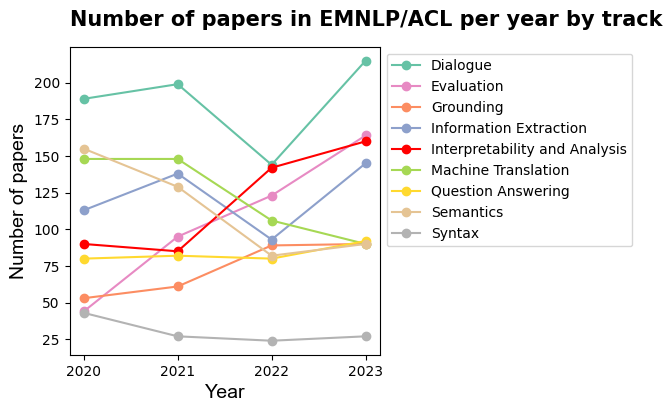

In [295]:
count_data = post_2020_df.groupby('year')['track'].value_counts().unstack().fillna(0)


tracks = count_data.columns
fig, ax = plt.subplots(figsize=(4, 4))
for track in tracks:
    ax.plot(count_data.index, count_data[track], marker='o', color=color_mapping[track], label=track)

plt.xlabel('Year', **axis_options)
plt.ylabel('Number of papers', **axis_options)
plt.title('Number of papers in EMNLP/ACL per year by track', loc='left', **title_options)
plt.tight_layout
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.show()


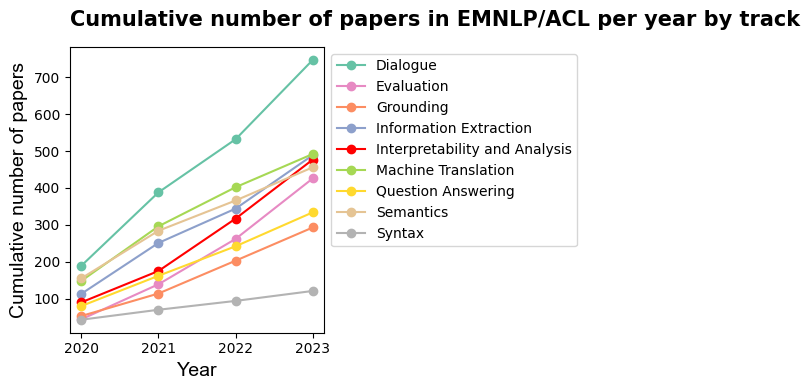

In [296]:
cumulative_data = count_data.cumsum()
tracks = cumulative_data.columns
fig, ax = plt.subplots(figsize=(4, 4))
for track in tracks:
    ax.plot(cumulative_data.index, cumulative_data[track], marker='o', color=color_mapping[track], label=track)

plt.xlabel('Year',  **axis_options)
plt.ylabel('Cumulative number of papers',  **axis_options)
plt.title('Cumulative number of papers in EMNLP/ACL per year by track', loc='left', **title_options)
plt.tight_layout()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


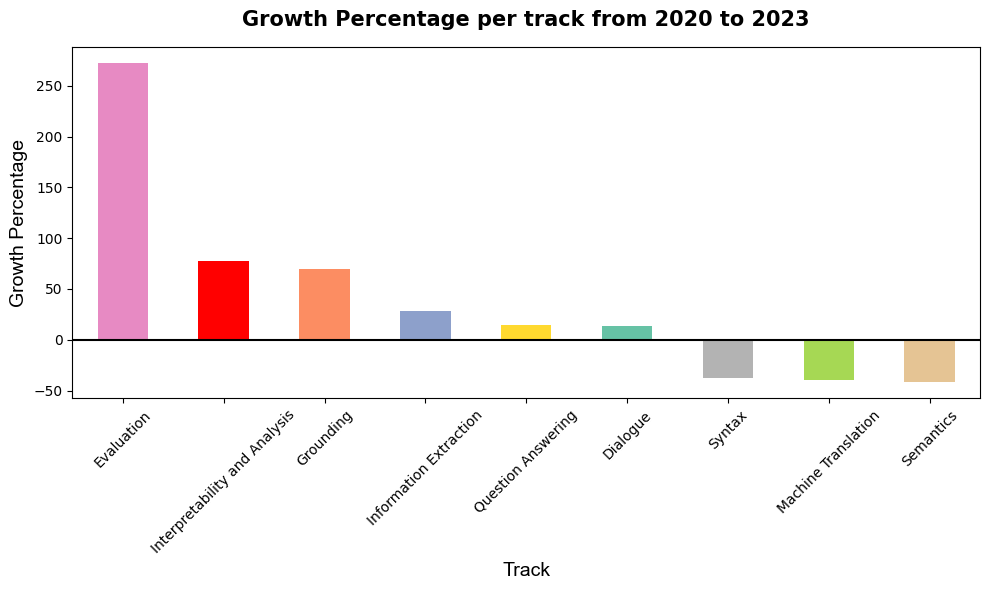

In [297]:
data_2020 = count_data.loc[2020]
data_2023 = count_data.loc[2023]
growth_percentage = ((data_2023 - data_2020) / data_2020) * 100

sorted_growth = growth_percentage.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_growth.plot(kind='bar', color=[color_mapping[track] for track in sorted_growth.index])

plt.xlabel('Track', **axis_options)
plt.ylabel('Growth Percentage', **axis_options)
plt.title('Growth Percentage per track from 2020 to 2023', **title_options)
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linewidth=1.5)
plt.tight_layout()

plt.show()


# Citation data by track

In [299]:
from utils import bulk_get_paper_details

post_2020_df = post_2020_df[~pd.isna(post_2020_df['semantic_scholar_id'])]

semantic_scholar_papers = bulk_get_paper_details(list(post_2020_df['semantic_scholar_id']))

Fetching papers: 14it [00:16,  1.17s/it]


In [300]:
# these papers cannot be found in the semantic scholar API,
# so we can gather this info manually from google scholar
doi_to_n_citations = {
    '10.18653/v1/2021.emnlp-main.582': 14,
    '10.48550/arXiv.2306.09802': 2,
    '10.18653/v1/2023.acl-long.835': 6,
    '10.18653/v1/2023.acl-long.725': 10,
    '10.18653/v1/2021.acl-long.148': 62,
    '10.18653/v1/2022.emnlp-main.650': 27,
    '10.18653/v1/2022.emnlp-main.674': 17,
    '10.18653/v1/2023.emnlp-main.385': 162,
    '10.18653/v1/2023.emnlp-main.616': 9
}



n_citations = []
for paper, doi in zip(semantic_scholar_papers, list(post_2020_df['doi'])):
    if paper is None:
        n_citations.append(doi_to_n_citations[doi])
    else:
        n_citations.append(paper.citation_count)
        
post_2020_df.loc[:, 'citation_count'] = n_citations

/var/folders/jd/xcxq41xd1bx5jvgpwp14tr940000gn/T/ipykernel_33896/2131435406.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_2020_df.loc[:, 'citation_count'] = n_citations


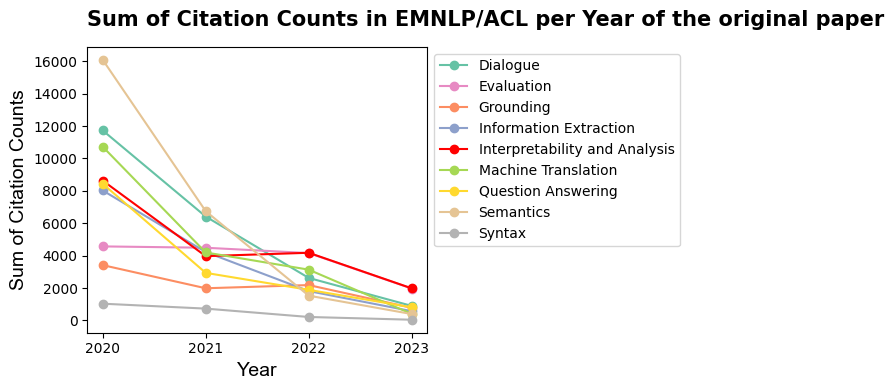

In [301]:
summed_data = post_2020_df.groupby(['year', 'track'])['citation_count'].sum().unstack().fillna(0)
tracks = summed_data.columns
fig, ax = plt.subplots(figsize=(7, 4))

for track in tracks:
    ax.plot(summed_data.index, summed_data[track], marker='o', color=color_mapping[track], label=track)

ax.set_xlabel('Year', **axis_options)
ax.set_ylabel('Sum of Citation Counts', **axis_options)
ax.set_title('Sum of Citation Counts in EMNLP/ACL per Year of the original paper', loc='left', **title_options)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()


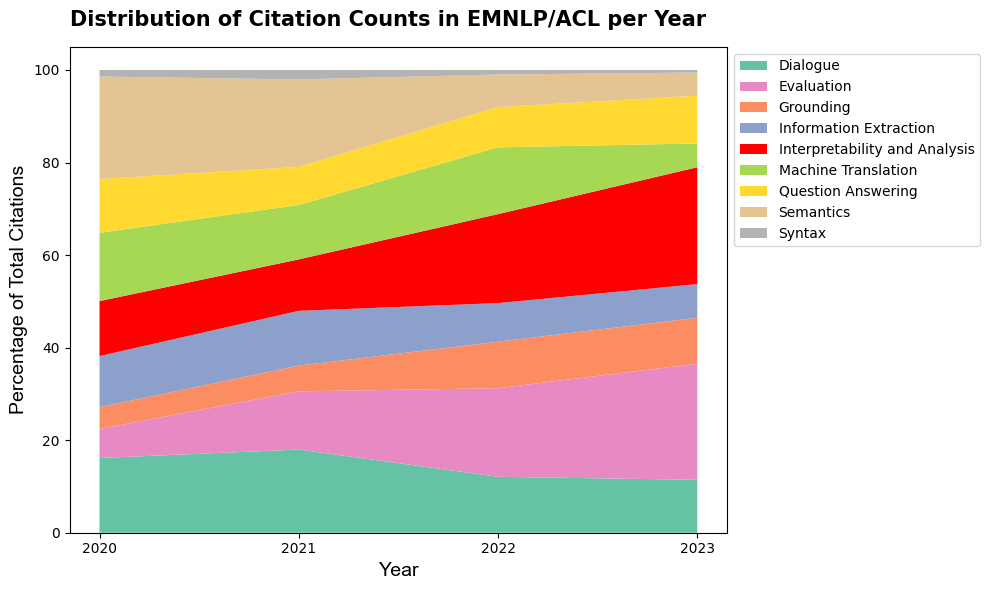

In [302]:
# of course, the older papers are more cited because they have been around longer.
# the interesting thing is that 2023 interpretability papers are the most cited (with evaluation)
# despite not being the track with the most submissions

# the distribution of citations to ACL/EMNLP by track over the years may be more fair

summed_data = post_2020_df.groupby(['year', 'track'])['citation_count'].sum().unstack().fillna(0)
percentage_data = summed_data.div(summed_data.sum(axis=1), axis=0) * 100

tracks = percentage_data.columns
fig, ax = plt.subplots(figsize=(10, 6))

ax.stackplot(percentage_data.index, [percentage_data[track] for track in tracks], labels=tracks, colors=[color_mapping[track] for track in tracks])

ax.set_xlabel('Year', **axis_options)
ax.set_ylabel('Percentage of Total Citations', **axis_options)
ax.set_title('Distribution of Citation Counts in EMNLP/ACL per Year', loc='left', **title_options)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

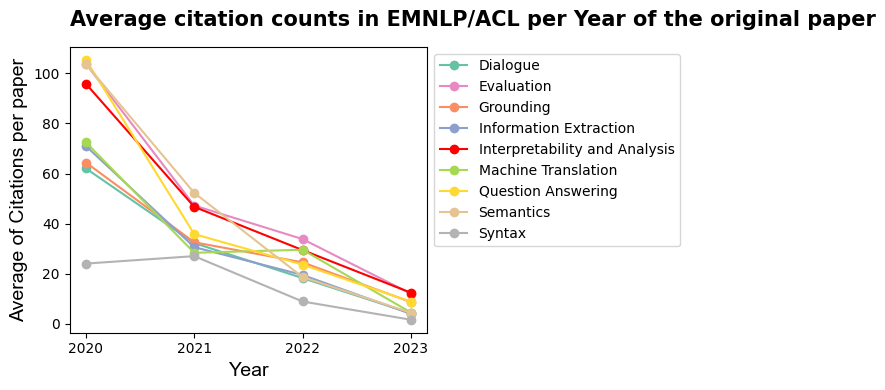

In [303]:
summed_data = post_2020_df.groupby(['year', 'track'])['citation_count'].mean().unstack().fillna(0)
tracks = summed_data.columns
fig, ax = plt.subplots(figsize=(7, 4))

for track in tracks:
    ax.plot(summed_data.index, summed_data[track], marker='o', color=color_mapping[track], label=track)

ax.set_xlabel('Year', **axis_options)
ax.set_ylabel('Average of Citations per paper', **axis_options)
ax.set_title('Average citation counts in EMNLP/ACL per Year of the original paper', loc='left', **title_options)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()


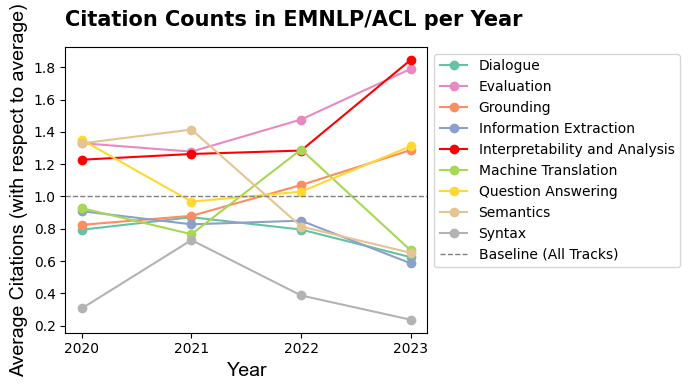

In [304]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

summed_data = post_2020_df.groupby(['year', 'track'])['citation_count'].mean().unstack().fillna(0)
overall_avg_citations = summed_data.mean(axis=1)

normalized_data = summed_data.div(overall_avg_citations, axis=0)

tracks = normalized_data.columns
fig, ax = plt.subplots(figsize=(7, 4))

for track in tracks:
    ax.plot(normalized_data.index, normalized_data[track], marker='o', color=color_mapping[track], label=track)

ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, label='Baseline (All Tracks)')
ax.set_xlabel('Year', **axis_options)
ax.set_ylabel('Average Citations (with respect to average)', **axis_options)
ax.set_title('Citation Counts in EMNLP/ACL per Year', loc='left', **title_options)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()


In [328]:
# from here onwards we use the citation graph

json_path = '../citationgraph/graph.json'
zip_path = '../citationgraph/graph.zip'

if not os.path.exists(json_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(zip_path))
    print("ZIP file extracted.")
 
with open(json_path) as f:
    graph_json = json.load(f)
    G = nx.cytoscape_graph(graph_json)

G.number_of_nodes()

185384

In [349]:
tracks = list(set(post_2020_df['track'].dropna()))
years = [2020, 2021, 2022, 2023] # years in which the interp track actually exists

citations_per_year = {track: {year: 0 for year in years} for track in tracks}

for cited_node, citing_node in tqdm(G.edges()):
    citing_year = G.nodes[citing_node]['year']
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue
    cited_year = G.nodes[cited_node]['year']
    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track is None:
        continue
    
    if cited_year < 2020:
        # interp started in 2020
        continue
        
    if citing_year is None or citing_year < 2020:
        # we'll ignore these 'impossible' cases
        # most of these are None values
        continue

    if citing_year > 2023:
        # we'll scope it till 2023 only
        continue
    citations_per_year[track][citing_year] += 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 786376/786376 [00:00<00:00, 887235.33it/s]


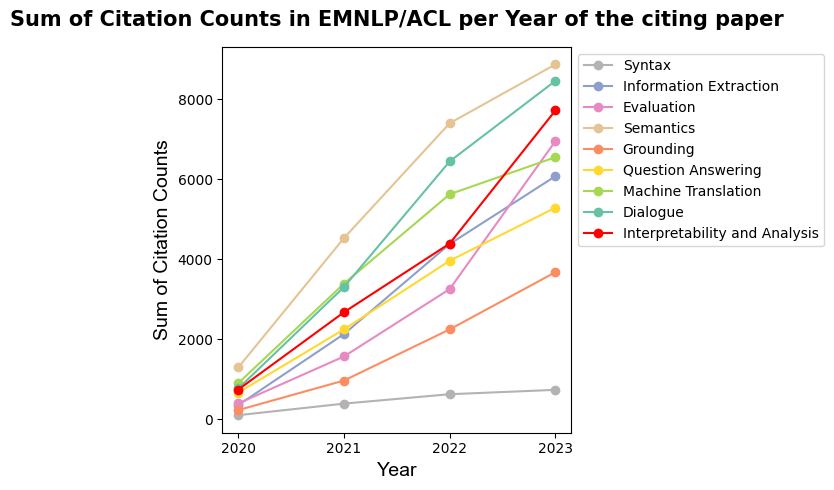

In [350]:
data = pd.DataFrame(citations_per_year, index=years)
fig, ax = plt.subplots(figsize=(7, 5))
for track in data.columns:
    ax.plot(data.index, data[track], marker='o', color=color_mapping[track], label=track)

ax.set_xlabel('Year', **axis_options)
ax.set_ylabel('Sum of Citation Counts', **axis_options)
ax.set_title('Sum of Citation Counts in EMNLP/ACL per Year of the citing paper', **title_options)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

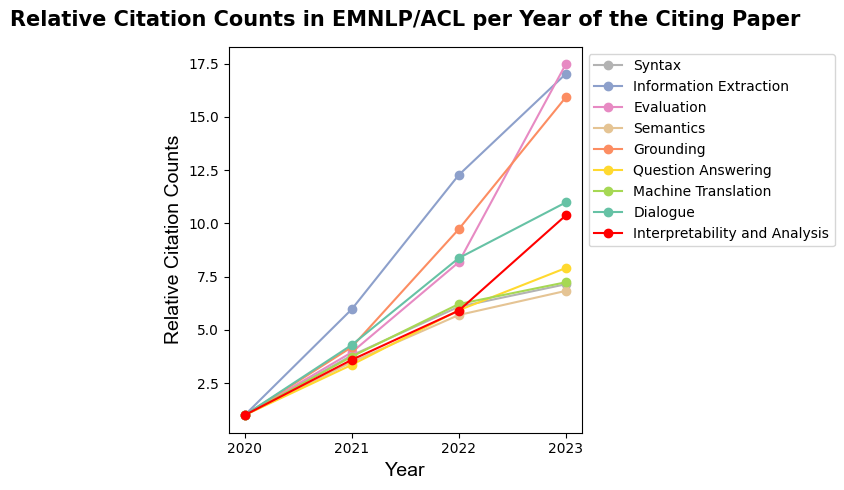

In [351]:
normalized_data = data.divide(data.iloc[0])

fig, ax = plt.subplots(figsize=(7, 5))

for track in normalized_data.columns:
    ax.plot(normalized_data.index, normalized_data[track], marker='o',color=color_mapping[track], label=track)

ax.set_xlabel('Year', **axis_options)
ax.set_ylabel('Relative Citation Counts', **axis_options)
ax.set_title('Relative Citation Counts in EMNLP/ACL per Year of the Citing Paper', **title_options)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

# Most influential papers per track

In [26]:
top_10_per_track = post_2020_df.groupby('track').apply(lambda x: x.nlargest(10, 'citation_count'))
top_10_per_track

/var/folders/jd/xcxq41xd1bx5jvgpwp14tr940000gn/T/ipykernel_33896/1862386437.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_per_track = post_2020_df.groupby('track').apply(lambda x: x.nlargest(10, 'citation_count'))


id                                              title  \
track                                                                         
Dialogue 778     cl.1508  The Design and Implementation of XiaoIce, an E...   
         56     main.372     GoEmotions: A Dataset of Fine-Grained Emotions   
         534    main.295  Relational Graph Attention Network for Aspect-...   
         6635      s1201  TOD-BERT: Pre-trained Natural Language Underst...   
         48       main.9  PLATO: Pre-trained Dialogue Generation Model w...   
...                  ...                                                ...   
Syntax   5969        NaN  MulDA: A Multilingual Data Augmentation Framew...   
         1004        642  MELM: Data Augmentation with Masked Entity Lan...   
         79     main.777  SeqVAT: Virtual Adversarial Training for Semi-...   
         787   tacl.1801  Deep Contextualized Self-training for Low Reso...   
         188    main.375  Do Neural Language Models Show Preferences for...   

                                                            area  \
track                                                              
Dialogue 778                    Dialogue and Interactive Systems   
         56    Sentiment Analysis, Stylistic Analysis, and Ar...   
         534   Sentiment Analysis, Stylistic Analysis, and Ar...   
         6635                     Dialog and Interactive Systems   
         48                     Dialogue and Interactive Systems   
...                                                          ...   
Syntax   5969             Syntax: Tagging, Chunking, and Parsing   
         1004              Syntax: Tagging, Chunking and Parsing   
         79                Syntax: Tagging, Chunking and Parsing   
         787               Syntax: Tagging, Chunking and Parsing   
         188               Syntax: Tagging, Chunking and Parsing   

              interpretability                             doi     source  \
track                                                                       
Dialogue 778             False            10.1162/coli_a_00368    ACL2020   
         56              False   10.18653/v1/2020.acl-main.372    ACL2020   
         534             False   10.18653/v1/2020.acl-main.295    ACL2020   
         6635            False  10.18653/v1/2020.emnlp-main.66  EMNLP2020   
         48              False     10.18653/v1/2020.acl-main.9    ACL2020   
...                        ...                             ...        ...   
Syntax   5969            False   10.18653/v1/2021.acl-long.453    ACL2021   
         1004            False   10.18653/v1/2022.acl-long.160    ACL2022   
         79              False   10.18653/v1/2020.acl-main.777    ACL2020   
         787             False            10.1162/tacl_a_00294    ACL2020   
         188             False   10.18653/v1/2020.acl-main.375    ACL2020   

               working_doi                                           abstract  \
track                                                                           
Dialogue 778          True  This article describes the development of Micr...   
         56           True  Understanding emotion expressed in language ha...   
         534          True  Aspect-based sentiment analysis aims to determ...   
         6635         True  The underlying difference of linguistic patter...   
         48           True  Pre-training models have been proved effective...   
...                    ...                                                ...   
Syntax   5969         True  Named Entity Recognition (NER) for low-resourc...   
         1004         True  Data augmentation is an effective solution to ...   
         79           True  Virtual adversarial training (VAT) is a powerf...   
         787          True  Abstract Neural dependency parsing has proven ...   
         188          True  Recent work on the interpretability of deep ne...   

                                                     

In [27]:
i = 1
for paper in list(top_10_per_track[top_10_per_track['track'] == 'Interpretability and Analysis']['title']):
    print('N°', i)
    print(paper)
    i += 1

N° 1
Rethinking the Role of Demonstrations: What Makes In-Context Learning Work?
N° 2
StereoSet: Measuring stereotypical bias in pretrained language models
N° 3
On the Cross-lingual Transferability of Monolingual Representations
N° 4
What BERT Is Not: Lessons from a New Suite of Psycholinguistic Diagnostics for Language Models
N° 5
Quantifying Attention Flow in Transformers
N° 6
ERASER: A Benchmark to Evaluate Rationalized NLP Models
N° 7
Towards Faithfully Interpretable NLP Systems: How Should We Define and Evaluate Faithfulness?
N° 8
Transformer Feed-Forward Layers Are Key-Value Memories
N° 9
Red Teaming Language Models with Language Models
N° 10
Dataset Cartography: Mapping and Diagnosing Datasets with Training Dynamics


In [28]:
i = 1
for paper in list(top_10_per_track[top_10_per_track['track'] == 'Evaluation']['title']):
    print('N°', i)
    print(paper)
    i += 1

N° 1
Beyond Accuracy: Behavioral Testing of NLP Models with CheckList
N° 2
Adversarial NLI: A New Benchmark for Natural Language Understanding
N° 3
TruthfulQA: Measuring How Models Mimic Human Falsehoods
N° 4
CLIPScore: A Reference-free Evaluation Metric for Image Captioning
N° 5
SummEval: Re-evaluating Summarization Evaluation
N° 6
Cross-Task Generalization via Natural Language Crowdsourcing Instructions
N° 7
Super-NaturalInstructions: Generalization via Declarative Instructions on 1600+ NLP Tasks
N° 8
S2ORC: The Semantic Scholar Open Research Corpus
N° 9
Is ChatGPT a General-Purpose Natural Language Processing Task Solver?
N° 10
MIND: A Large-scale Dataset for News Recommendation


In [29]:
i = 1
for paper in list(top_10_per_track[top_10_per_track['track'] == 'Machine Translation']['title']):
    print('N°', i)
    print(paper)
    i += 1

N° 1
Multilingual Denoising Pre-training for Neural Machine Translation
N° 2
Making Monolingual Sentence Embeddings Multilingual using Knowledge Distillation
N° 3
COMET: A Neural Framework for MT Evaluation
N° 4
Language-agnostic BERT Sentence Embedding
N° 5
MAD-X: An Adapter-Based Framework for Multi-Task Cross-Lingual Transfer
N° 6
The FLORES-101 Evaluation Benchmark for Low-Resource and Multilingual Machine Translation
N° 7
Improving Massively Multilingual Neural Machine Translation and Zero-Shot Translation
N° 8
ByT5: Towards a Token-Free Future with Pre-trained Byte-to-Byte Models
N° 9
 XGLUE: A New Benchmark Datasetfor Cross-lingual Pre-training, Understanding and Generation
N° 10
From Zero to Hero: On the Limitations of Zero-Shot Language Transfer with Multilingual Transformers


# Citations comparing analysis/interpretability vs non

## Is interpretability just citing itself?

In [363]:
from collections import defaultdict

interp_citation_counts = defaultdict(int)
non_interp_citation_counts = defaultdict(int)

for cited_node, citing_node in G.edges():
    # check that the cited node is from the dataset
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue

    # check that it was an interp paper
    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track != 'Interpretability and Analysis':
        continue

    # check that we have a prediction on whether the citing paper was interp or not
    if 'interpretability_prediction' not in G.nodes[citing_node]:
        continue
    interp = G.nodes[citing_node]['interpretability_prediction']
    if interp is None:
        continue


    citing_year = G.nodes[citing_node]['year']
    if interp is None:
        continue
    if citing_year and 2018 <= citing_year <= 2023:
        if interp:
            interp_citation_counts[citing_year] += 1
        else:
            non_interp_citation_counts[citing_year] += 1

interp_citation_counts, non_interp_citation_counts

(defaultdict(int,
             {2023: 2757,
              2022: 1826,
              2021: 1223,
              2020: 342,
              2018: 1,
              2019: 16}),
 defaultdict(int,
             {2023: 4636,
              2022: 2360,
              2021: 1294,
              2020: 374,
              2019: 10,
              2018: 4}))

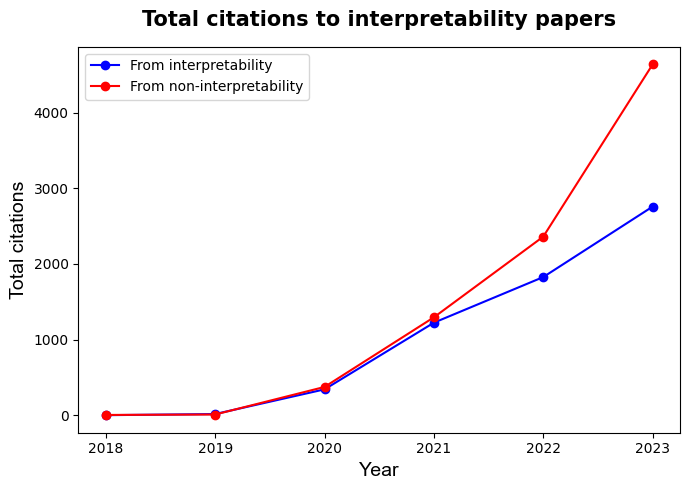

In [364]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.set_xlabel('Year', **axis_options)
ax.set_ylabel('Total citations', **axis_options)

years = [2018, 2019, 2020, 2021, 2022, 2023]
data_interp = pd.DataFrame({'Interpretability': [interp_citation_counts.get(year, 0) for year in years]}, index=years)
data_non_interp = pd.DataFrame({'Non-Interpretability': [non_interp_citation_counts.get(year, 0) for year in years]}, index=years)

ax.plot(data_interp.index, data_interp['Interpretability'], marker='o', color='blue', label='From interpretability')
ax.plot(data_non_interp.index, data_non_interp['Non-Interpretability'], marker='o', color='red', label='From non-interpretability')

ax.tick_params(axis='y')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend()

plt.title('Total citations to interpretability papers', **title_options)
plt.tight_layout()
plt.show()

In [473]:
#### how does the previous plot compare to MT?
from collections import defaultdict

mt_citation_counts = defaultdict(int)
non_mt_citation_counts = defaultdict(int)

for cited_node, citing_node in G.edges():
    # check that the cited node is from the dataset
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue

    # check that it was an interp paper
    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track != 'Machine Translation':
        continue

    # check that we have a prediction on whether the citing paper was interp or not
    if 'mt_prediction' not in G.nodes[citing_node]:
        continue
    mt = G.nodes[citing_node]['mt_prediction']
    if mt is None:
        continue


    citing_year = G.nodes[citing_node]['year']
    if mt is None:
        continue
    if citing_year and 2018 <= citing_year <= 2023:
        if mt:
            mt_citation_counts[citing_year] += 1
        else:
            non_mt_citation_counts[citing_year] += 1

mt_citation_counts, non_mt_citation_counts

(defaultdict(int,
             {2023: 3862,
              2022: 3974,
              2021: 3412,
              2020: 2242,
              2019: 1192,
              2018: 208}),
 defaultdict(int,
             {2023: 4580,
              2022: 3881,
              2021: 2670,
              2020: 1610,
              2019: 822,
              2018: 121}))

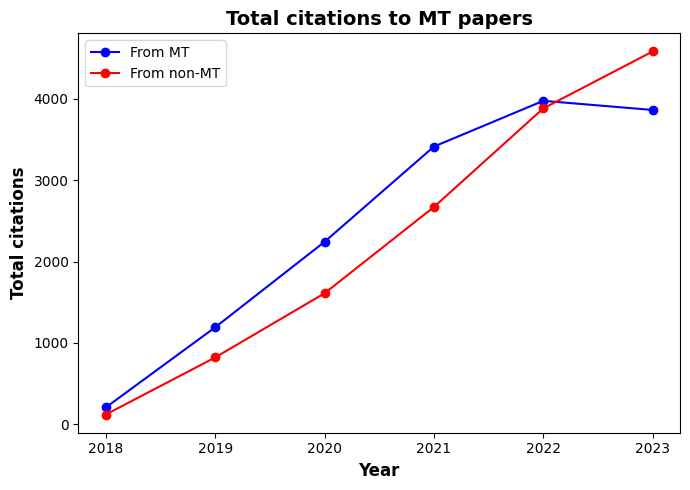

In [474]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.set_xlabel('Year', **axis_options)
ax.set_ylabel('Total citations', **axis_options)

years = [2018, 2019, 2020, 2021, 2022, 2023]
data_mt = pd.DataFrame({'MT': [mt_citation_counts.get(year, 0) for year in years]}, index=years)
data_non_mt = pd.DataFrame({'Non-MT': [non_mt_citation_counts.get(year, 0) for year in years]}, index=years)

ax.plot(data_interp.index, data_mt['MT'], marker='o', color='blue', label='From MT')
ax.plot(data_non_interp.index, data_non_mt['Non-MT'], marker='o', color='red', label='From non-MT')

ax.tick_params(axis='y')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.legend()

plt.title('Total citations to MT papers', **title_options)
plt.tight_layout()
plt.show()

## How much are non interpretability papers actually citing interpretability?

In [470]:
non_interp_citation_distribution = { year: [] for year in years }

for node in tqdm(G.nodes()):
    # check that the node is an interp paper from our dataset
    if G.nodes[node]['originally_from_dataset'] is not True:
        continue
    track = raw_track_to_track(G.nodes[node]['area'])
    if track == 'Interpretability and Analysis' :
        continue

    
    references = G.in_edges(node)
    interp = 0
    non_interp = 0
    for reference, self in references:
        assert(self == node)
        # we still have papers with no prediction
        if 'interpretability_prediction' not in G.nodes[reference]:
            continue
        interp_citation = G.nodes[reference]['interpretability_prediction']
        if interp_citation is None:
            continue

        
        if interp_citation:
            interp += 1
        else:
            non_interp += 1
    
    total = interp + non_interp
    if total == 0:
        # some papers have no references according to semantic scholar
        # (they do have, but semantic scholar does not recognize them)
        continue
        
    interp_percentage = interp /(non_interp + interp) * 100
    year = G.nodes[node]['year']
    non_interp_citation_distribution[year].append(interp_percentage)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185384/185384 [00:00<00:00, 392876.72it/s]


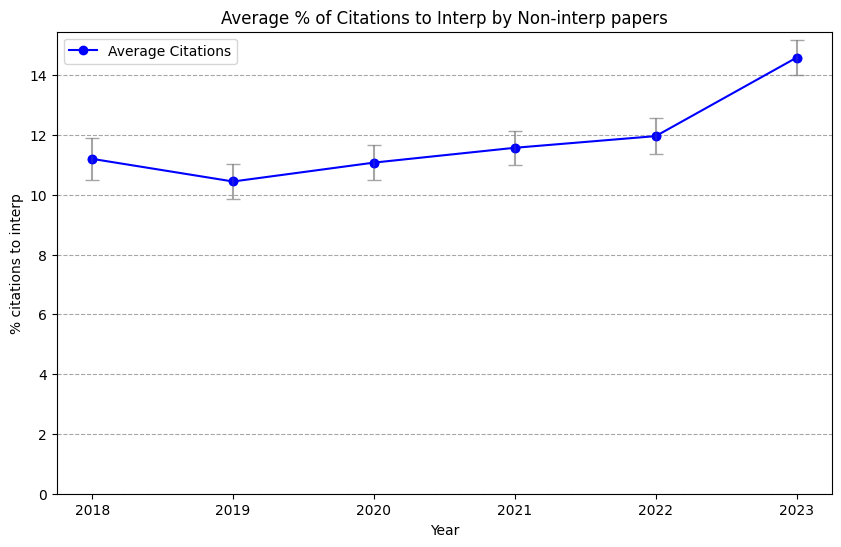

In [471]:
averages = [np.mean(non_interp_citation_distribution[year]) for year in years]
standard_errors = [np.std(non_interp_citation_distribution[year], ddof=1) / np.sqrt(len(non_interp_citation_distribution[year])) for year in years]

std_to_get_to_95_conf = 1.96
confidence_intervals = [std_to_get_to_95_conf * se for se in standard_errors]

fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(years, averages, 'o-', color='blue', label='Average Citations')
ax.errorbar(years, averages, yerr=confidence_intervals, fmt='o', color='blue', ecolor='gray', alpha=0.7, capsize=5)

ax.set_xlabel('Year')
ax.set_ylabel('% citations to interp')
ax.set_title('Average % of Citations to Interp by Non-interp papers')
ax.set_ylim(bottom=0)

ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.legend()
plt.show()

In [467]:
#### how does the previous plot compare to MT?
years = [2018, 2019, 2020, 2021, 2022, 2023]
non_mt_citation_distribution = { year: [] for year in years }

for node in tqdm(G.nodes()):
    # check that the node is an interp paper from our dataset
    if G.nodes[node]['originally_from_dataset'] is not True:
        continue
    track = raw_track_to_track(G.nodes[node]['area'])
    if track == 'Machine Translation' :
        continue

    
    references = G.in_edges(node)
    mt = 0
    non_mt = 0
    for reference, self in references:
        assert(self == node)
        # we still have papers with no prediction
        if 'mt_prediction' not in G.nodes[reference]:
            continue
        mt_citation = G.nodes[reference]['mt_prediction']
        if mt_citation is None:
            continue

        
        if mt_citation:
            mt += 1
        else:
            non_mt += 1
    
    total = mt + non_mt
    if total == 0:
        # some papers have no references according to semantic scholar
        # (they do have, but semantic scholar does not recognize them)
        continue
        
    mt_percentage = mt /(non_mt + mt) * 100
    year = G.nodes[node]['year']
    non_mt_citation_distribution[year].append(mt_percentage)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185384/185384 [00:00<00:00, 323442.55it/s]


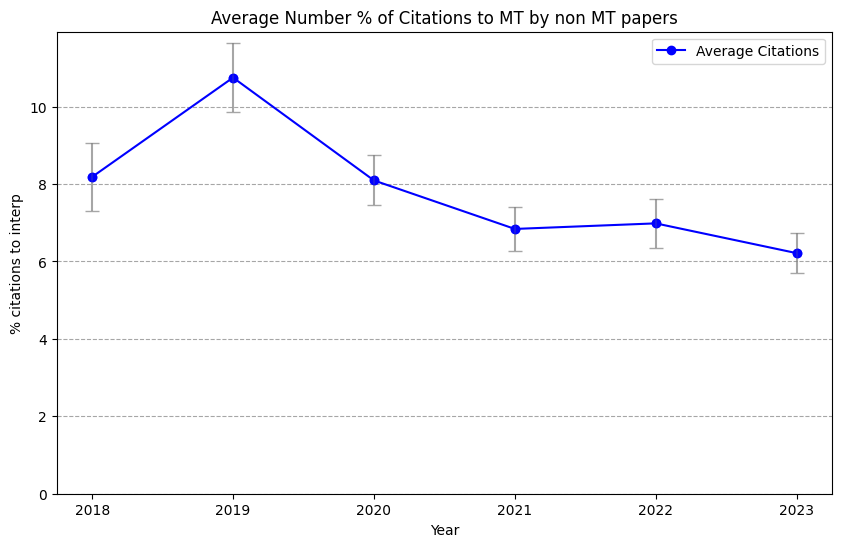

In [472]:
averages = [np.mean(non_mt_citation_distribution[year]) for year in years]
standard_errors = [np.std(non_mt_citation_distribution[year], ddof=1) / np.sqrt(len(non_mt_citation_distribution[year])) for year in years]

std_to_get_to_95_conf = 1.96
confidence_intervals = [std_to_get_to_95_conf * se for se in standard_errors]

fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(years, averages, 'o-', color='blue', label='Average Citations')
ax.errorbar(years, averages, yerr=confidence_intervals, fmt='o', color='blue', ecolor='gray', alpha=0.7, capsize=5)

ax.set_xlabel('Year')
ax.set_ylabel('% citations to interp')
ax.set_title('Average Number % of Citations to MT by non MT papers')
ax.set_ylim(bottom=0)

ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.legend()
plt.show()

## Which tracks cite interpretability the most (outside of interp)?

In [396]:
citation_distribution_by_track = { track: {year: [] for year in years} for track in tracks }

for node in tqdm(G.nodes()):
    # check that the node is an interp paper from our dataset
    if G.nodes[node]['originally_from_dataset'] is not True:
        continue
    track = raw_track_to_track(G.nodes[node]['area'])
    if track == 'Interpretability and Analysis' or track is None:
        continue

    
    references = G.in_edges(node)
    interp = 0
    non_interp = 0
    for reference, self in references:
        assert(self == node)
        # we still have papers with no prediction
        if 'interpretability_prediction' not in G.nodes[reference]:
            continue
        interp_citation = G.nodes[reference]['interpretability_prediction']
        if interp_citation is None:
            continue

        
        if interp_citation:
            interp += 1
        else:
            non_interp += 1
    
    total = interp + non_interp
    if total == 0:
        # some papers have no references according to semantic scholar
        # (they do have, but semantic scholar does not recognize them)
        continue
        
    interp_percentage = interp /(non_interp + interp) * 100
    year = G.nodes[node]['year']
    citation_distribution_by_track[track][year].append(interp_percentage)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185384/185384 [00:00<00:00, 453691.20it/s]


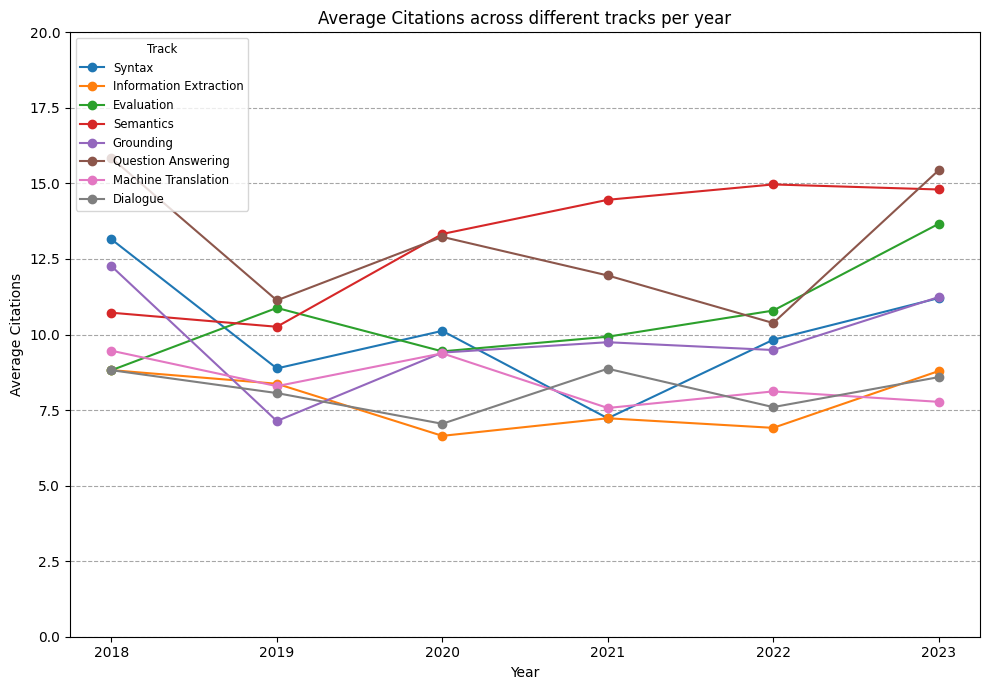

In [398]:
import scipy.stats as stats
conf_interval = 0.95
fig, ax = plt.subplots(figsize=(10, 7))

for track in tracks:
    if track == 'Interpretability and Analysis':
        continue
    mean_citations = []
    ci_lower = []
    ci_upper = []

    for year in years:
        data = citation_distribution_by_track[track][year]
        mean_val = np.mean(data)
        ci = stats.t.interval(conf_interval, len(data)-1, loc=mean_val, scale=stats.sem(data))
        mean_citations.append(mean_val)
        ci_lower.append(ci[0])
        ci_upper.append(ci[1])

    ax.plot(years, mean_citations, 'o-', label=track)
    # ax.fill_between(years, ci_lower, ci_upper, alpha=0.15)

ax.set_xlabel('Year')
ax.set_ylabel('Average Citations')
ax.set_ylim(bottom=0)
ax.set_ylim(top=20)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)
ax.legend(title='Track', loc='upper left', fontsize='small', title_fontsize='small')
plt.title('Average Citations across different tracks per year')
plt.tight_layout()
plt.show()

## How does the distribution of % of cited papers corresponding interp look like?

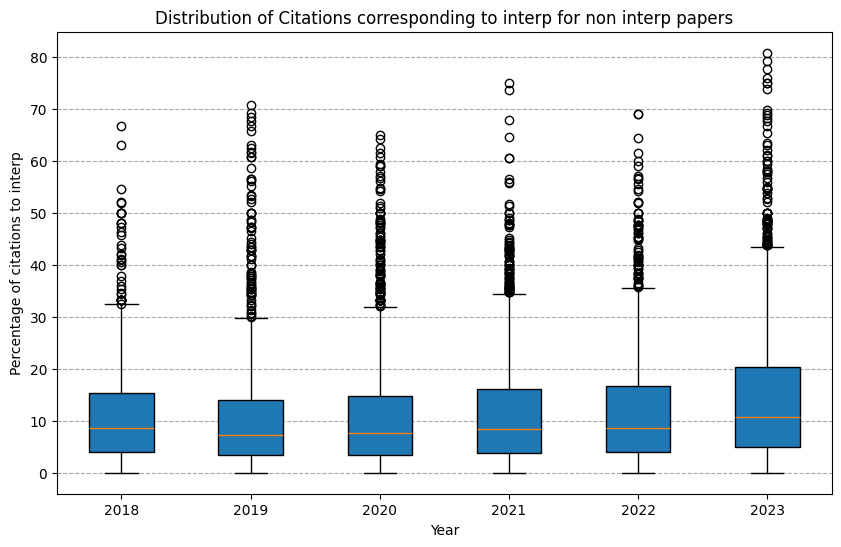

In [400]:
data_to_plot = [non_interp_citation_distribution[year] for year in years]

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(data_to_plot, labels=years, patch_artist=True)

ax.set_xlabel('Year')
ax.set_ylabel('Percentage of citations to interp')
ax.set_title('Distribution of Citations corresponding to interp for non interp papers')

ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)
ax.set_axisbelow(True)

plt.show()

## Are interpretability/analysis citations influential?

In [447]:
tracks = list(set(post_2020_df['track'].dropna()))
years = [2020, 2021, 2022, 2023] # years in which the interp track actually exists


citations = { track: defaultdict(int) for track in tracks }
non_citations = { track: defaultdict(int) for track in tracks }

for cited_node, citing_node in tqdm(G.edges()):
    citing_year = G.nodes[citing_node]['year']
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue
    cited_year = G.nodes[cited_node]['year']
    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track is None:
        continue
    

    citation_info = G.get_edge_data(cited_node, citing_node)
    if citation_info['is_influential']:
        citations[track][cited_year] += 1
    else:
        non_citations[track][cited_year] += 1



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 786376/786376 [00:00<00:00, 811926.41it/s]


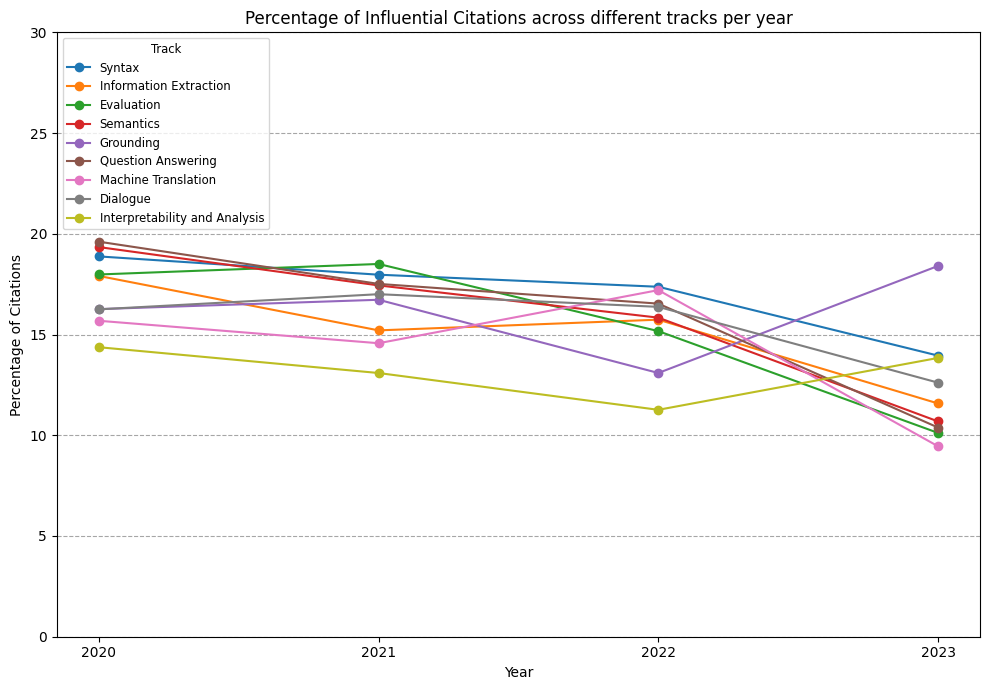

In [448]:

conf_interval = 0.95
fig, ax = plt.subplots(figsize=(10, 7))

for track in tracks:
    percentages = []
    ci_lower = []
    ci_upper = []
    
    for year in years:
        total = citations[track][year] + non_citations[track][year]
        if total == 0:
            continue
        percentage = (citations[track][year] / total) * 100
        percentages.append(percentage)
        
        standard_error = np.sqrt((percentage * (100 - percentage)) / total)
        ci = stats.norm.interval(conf_interval, loc=percentage, scale=standard_error)
        ci_lower.append(ci[0])
        ci_upper.append(ci[1])
    
    ax.plot(years, percentages, 'o-', label=track)
    ax.fill_between(years, ci_lower, ci_upper, alpha=0.15)

ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Citations')
ax.set_ylim(bottom=0, top=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)
ax.legend(title='Track', loc='upper left', fontsize='small', title_fontsize='small')
plt.title('Percentage of Influential Citations across different tracks per year')
plt.tight_layout()
plt.show()


## Are citations of interpretability outside of its area more influential than other tracks?

In [438]:
influential_interp =  defaultdict(int)
non_influential_interp =  defaultdict(int)

for cited_node, citing_node in tqdm(G.edges()):
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue
    cited_year = G.nodes[cited_node]['year']
    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track != 'Interpretability and Analysis':
        continue

    if 'interpretability_prediction' not in G.nodes[cited_node]:
        continue
    interp = G.nodes[cited_node]['interpretability_prediction']
    if interp is None or interp is True:
        continue
    assert(interp is False)

    
    citation_info = G.get_edge_data(cited_node, citing_node)
    if citation_info['is_influential']:
        influential_interp[cited_year] += 1
    else:
        non_influential_interp[cited_year] += 1

influential_interp, non_influential_interp

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 786376/786376 [00:01<00:00, 635999.55it/s]


(defaultdict(int, {2020: 46, 2021: 14, 2022: 56, 2023: 40}),
 defaultdict(int, {2020: 390, 2021: 102, 2022: 293, 2023: 268}))

In [439]:
influential_mt =  defaultdict(int)
non_influential_mt =  defaultdict(int)

for cited_node, citing_node in tqdm(G.edges()):
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue
    cited_year = G.nodes[cited_node]['year']
    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track != 'Machine Translation':
        continue

    if 'mt_prediction' not in G.nodes[cited_node]:
        continue
    interp = G.nodes[cited_node]['mt_prediction']
    if interp is None or interp is True:
        continue
    assert(interp is False)

    
    citation_info = G.get_edge_data(cited_node, citing_node)
    if citation_info['is_influential']:
        influential_mt[cited_year] += 1
    else:
        non_influential_mt[cited_year] += 1

influential_mt, non_influential_mt

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 786376/786376 [00:00<00:00, 1288443.74it/s]


(defaultdict(int, {2020: 104, 2021: 4, 2022: 51, 2018: 37, 2019: 5, 2023: 2}),
 defaultdict(int,
             {2020: 458, 2021: 46, 2022: 266, 2023: 11, 2018: 246, 2019: 74}))

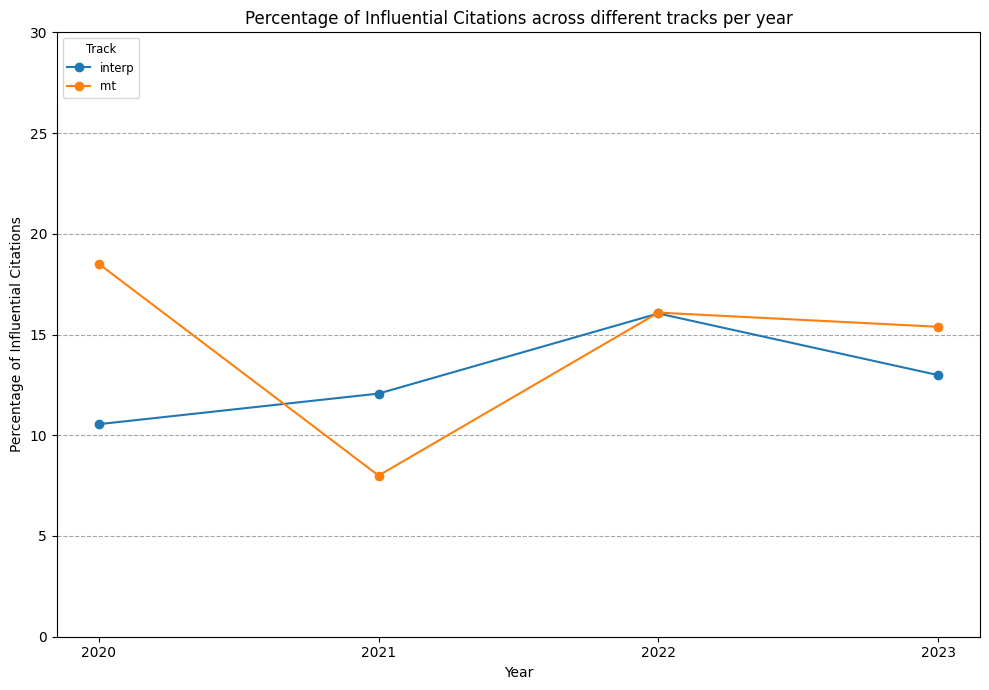

In [449]:

fig, ax = plt.subplots(figsize=(10, 7))

interp_percentages = []
for year in years:
    total = influential_interp[year] + non_influential_interp[year]
    if total == 0:
        continue
    percentage = (influential_interp[year] / total) * 100
    interp_percentages.append(percentage)
ax.plot(years, interp_percentages, 'o-', label='interp')
    
mt_percentages = []
for year in years:
    total = influential_mt[year] + non_influential_mt[year]
    if total == 0:
        continue
    percentage = (influential_mt[year] / total) * 100
    mt_percentages.append(percentage)
ax.plot(years, mt_percentages, 'o-', label='mt')

ax.set_xlabel('Year')
ax.set_ylabel('Percentage of Influential Citations')
ax.set_ylim(bottom=0, top=30)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)
ax.legend(title='Track', loc='upper left', fontsize='small', title_fontsize='small')
plt.title('Percentage of Influential Citations across different tracks per year')
plt.tight_layout()
plt.show()


## Where is interpretability being cited?

In [458]:
years = [2020, 2021, 2022, 2023]
metrics = ['background', 'result', 'methodology']

citations = { track: { year: { metric: {True: 0, False: 0} for metric in metrics } for year in years } for track in tracks }

for cited_node, citing_node in tqdm(G.edges()):
    if G.nodes[cited_node]['originally_from_dataset'] is not True:
        continue
    year = G.nodes[cited_node]['year']
    if year not in years:
        continue
    track = raw_track_to_track(G.nodes[cited_node]['area'])
    if track is None:
        continue
    

    citation_info = G.get_edge_data(cited_node, citing_node)
    for metric in metrics:
        value = citation_info[metric]
        citations[track][year][metric][value] += 1
    

citations

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 786376/786376 [00:00<00:00, 1394595.23it/s]


{'Syntax': {2020: {'background': {True: 511, False: 522},
   'result': {True: 44, False: 989},
   'methodology': {True: 429, False: 604}},
  2021: {'background': {True: 309, False: 420},
   'result': {True: 22, False: 707},
   'methodology': {True: 270, False: 459}},
  2022: {'background': {True: 114, False: 99},
   'result': {True: 8, False: 205},
   'methodology': {True: 79, False: 134}},
  2023: {'background': {True: 20, False: 23},
   'result': {True: 2, False: 41},
   'methodology': {True: 16, False: 27}}},
 'Information Extraction': {2020: {'background': {True: 3782, False: 4237},
   'result': {True: 250, False: 7769},
   'methodology': {True: 3287, False: 4732}},
  2021: {'background': {True: 1963, False: 2259},
   'result': {True: 112, False: 4110},
   'methodology': {True: 1514, False: 2708}},
  2022: {'background': {True: 840, False: 971},
   'result': {True: 56, False: 1755},
   'methodology': {True: 649, False: 1162}},
  2023: {'background': {True: 274, False: 296},
   'res

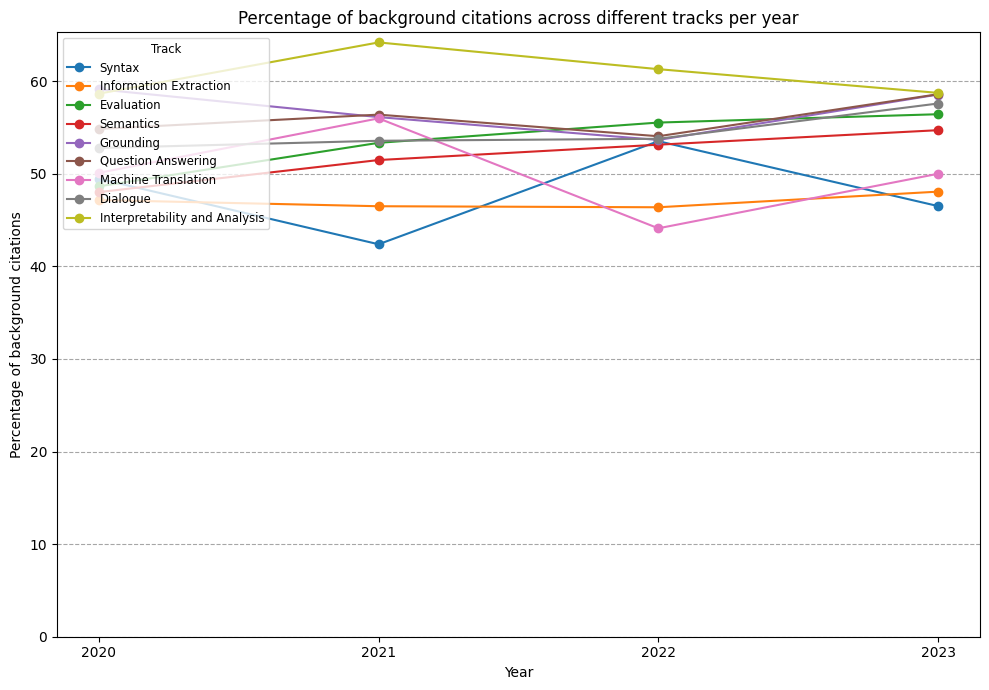

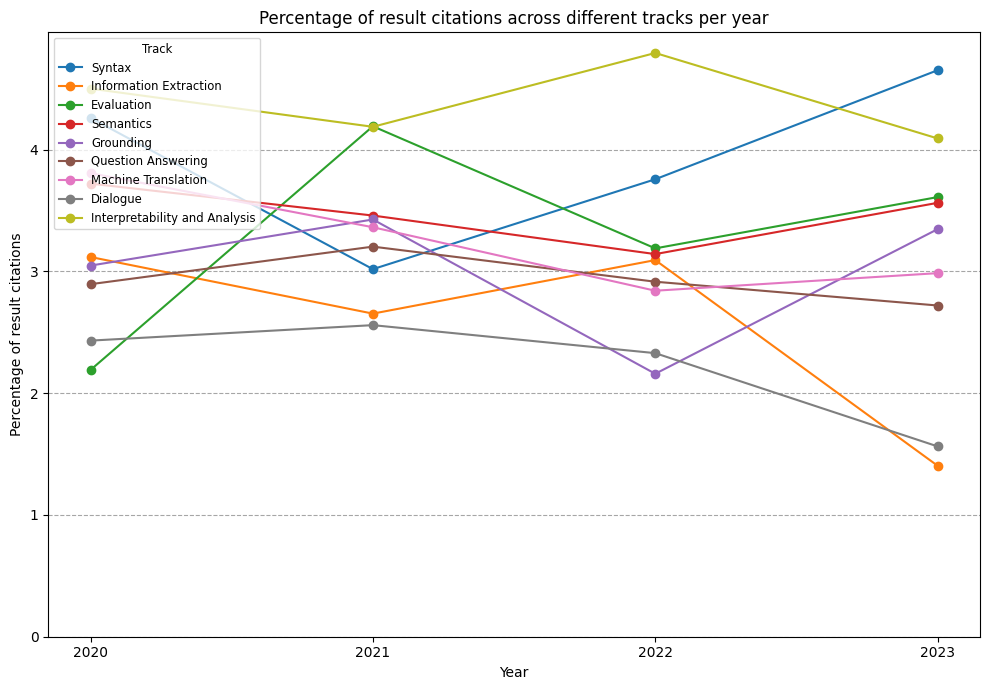

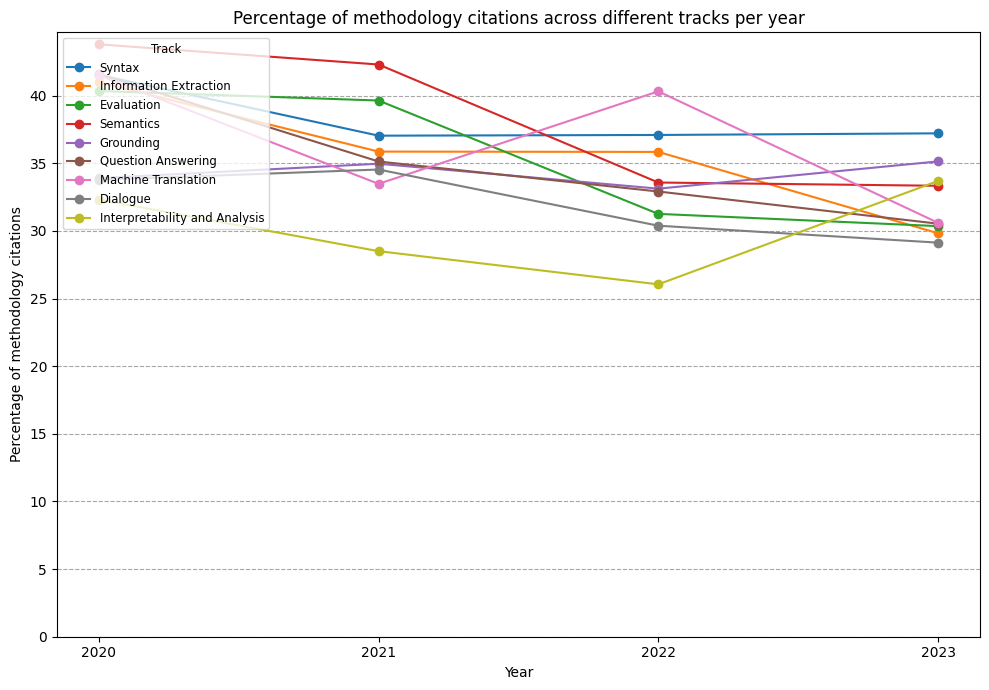

In [464]:
conf_interval = 0.95

for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 7))
    for track in tracks:
        percentages = []
        ci_lower = []
        ci_upper = []

        for year in years:
            data = citations[track][year][metric]
            total = sum(data.values())
            if total == 0:
                continue
            percentage = (data[True] / total) * 100
            percentages.append(percentage)

            standard_error = np.sqrt((percentage * (100 - percentage)) / total)
            ci = stats.norm.interval(conf_interval, loc=percentage, scale=standard_error)
            ci_lower.append(ci[0])
            ci_upper.append(ci[1])

        ax.plot(years, percentages, 'o-', label=track)
        # ax.fill_between(years, ci_lower, ci_upper, alpha=0.15)

    ax.set_xlabel('Year')
    ax.set_ylabel(f'Percentage of {metric} citations')
    ax.set_ylim(bottom=0)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.7)
    ax.legend(title='Track', loc='upper left', fontsize='small', title_fontsize='small')
    plt.title(f'Percentage of {metric} citations across different tracks per year')
    plt.tight_layout()
    plt.show()